In [1]:
import pandas as pd
import numpy as np
import time
import ccxt
from ccxt.base.errors import RequestTimeout
from datetime import datetime, timedelta

In [2]:
df = pd.read_csv('./data/pump_telegram.csv')

binance_only = df[df['exchange'] == 'binance']

In [3]:
# binance_only.to_csv('binance_only.csv', index=False)
binance_2020 = binance_only[binance_only['date'] > '2020-01-01']
binance_2020.sort_values(by='date', ascending = True,inplace=True)

/var/folders/73/0sh0srn11ks71w93th8nzgl40000gn/T/ipykernel_78326/2867594572.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binance_2020.sort_values(by='date', ascending = True,inplace=True)


In [4]:
binance_2020

,symbol,group,date,hour,exchange
877,DLT,CW,2020-01-04,20:00,binance
1055,EDO,CPI,2020-01-08,17:05,binance
1056,ONG,CPI,2020-01-09,17:00,binance
1057,GNT,CPI,2020-01-10,18:00,binance
796,VIB,BPF,2020-01-12,20:00,binance
...,...,...,...,...,...
875,ONG,BPF,2021-01-11,16:00,binance
646,APPC,CP,2021-01-13,21:00,binance
638,NXS,TWP,2021-01-15,17:00,binance
876,NXS,BPF,2021-01-15,17:00,binance


In [5]:
import requests
import time
from datetime import datetime, timedelta

API_BASE = 'https://api.binance.com/api/v3/klines'

def retrieve_klines(symbol, interval, startTime=None, endTime=None, limit=1000):
    params = {
        'symbol': symbol,
        'interval': interval,
        'startTime': int(startTime) if startTime else None,
        'endTime': int(endTime) if endTime else None,
        'limit': limit
    }

    response = requests.get(API_BASE, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error {response.status_code}: {response.text}")
        return []

def get_klines(symbol='ETHBTC', interval='1m', start=None, end=None):
    max_candles = 1000
    candle_duration = timedelta(minutes=1)
    delta = max_candles * candle_duration

    all_klines = []
    current = start

    while current < end:
        start_ms = int(current.timestamp() * 1000)
        next_time = min(current + delta, end)
        end_ms = int(next_time.timestamp() * 1000)

        print(f"Fetching: {current} -> {next_time}")
        data = retrieve_klines(symbol, interval, startTime=start_ms, endTime=end_ms)
        if not data:
            break

        all_klines.extend(data)
        current = datetime.fromtimestamp(data[-1][0] / 1000) + candle_duration
        time.sleep(0.3)  # Respect Binance API rate limits

    return all_klines

In [6]:
days_before = 7
days_after = 7

# To replace with automated to get all instances of pumps, for now this only retrieves DLT with 7 days before and after the pump
symbol = binance_2020.iloc[0]['symbol']
pump_time = binance_2020.iloc[0]['date'] + ' ' + binance_2020.iloc[0]['hour']
print(f'Symbol: {symbol}\nPump-time: {pump_time}')

pump_time_dt = datetime.strptime(pump_time, "%Y-%m-%d %H:%M")
before = pump_time_dt-timedelta(days=days_before)
after = pump_time_dt+timedelta(days=days_after)


full_symbol = symbol.upper() + 'BTC'
klines = get_klines(full_symbol, '1m', start=before, end=after)

print(f"Retrieved {len(klines)} klines.")


Symbol: DLT
Pump-time: 2020-01-04 20:00
Fetching: 2019-12-28 20:00:00 -> 2019-12-29 12:40:00
Fetching: 2019-12-29 12:40:00 -> 2019-12-30 05:20:00
Fetching: 2019-12-30 05:20:00 -> 2019-12-30 22:00:00
Fetching: 2019-12-30 22:00:00 -> 2019-12-31 14:40:00
Fetching: 2019-12-31 14:40:00 -> 2020-01-01 07:20:00
Fetching: 2020-01-01 07:20:00 -> 2020-01-02 00:00:00
Fetching: 2020-01-02 00:00:00 -> 2020-01-02 16:40:00
Fetching: 2020-01-02 16:40:00 -> 2020-01-03 09:20:00
Fetching: 2020-01-03 09:20:00 -> 2020-01-04 02:00:00
Fetching: 2020-01-04 02:00:00 -> 2020-01-04 18:40:00
Fetching: 2020-01-04 18:40:00 -> 2020-01-05 11:20:00
Fetching: 2020-01-05 11:20:00 -> 2020-01-06 04:00:00
Fetching: 2020-01-06 04:00:00 -> 2020-01-06 20:40:00
Fetching: 2020-01-06 20:40:00 -> 2020-01-07 13:20:00
Fetching: 2020-01-07 13:20:00 -> 2020-01-08 06:00:00
Fetching: 2020-01-08 06:00:00 -> 2020-01-08 22:40:00
Fetching: 2020-01-08 22:40:00 -> 2020-01-09 15:20:00
Fetching: 2020-01-09 15:20:00 -> 2020-01-10 08:00:00
Fetchi

/Users/joshuarenzodorado/pump-and-dump-dataset-master/project_env/lib/python3.13/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


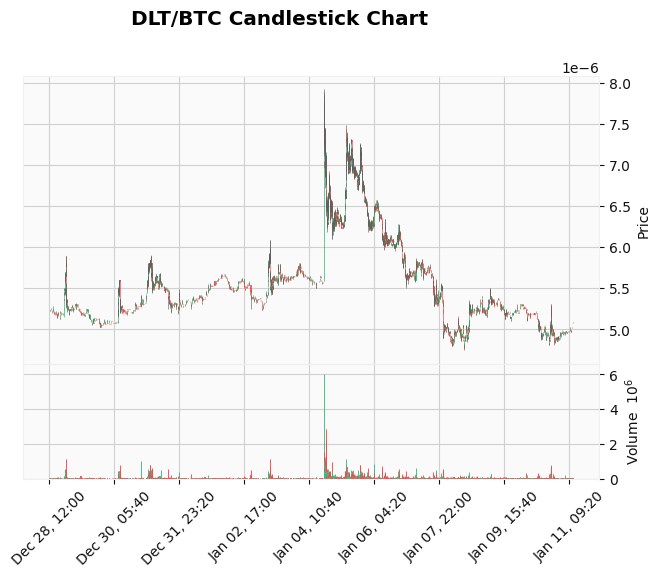

In [7]:
import pandas as pd
import mplfinance as mpf

# Convert raw eth_btc data to a DataFrame
df = pd.DataFrame(klines, columns=[
    'Open time', 'Open', 'High', 'Low', 'Close', 'Volume',
    'Close time', 'Quote asset volume', 'Number of trades',
    'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'
])

# Convert 'Open time' to datetime and set as index
df['Open time'] = pd.to_datetime(df['Open time'], unit='ms')
df.set_index('Open time', inplace=True)

# Convert necessary columns to float
float_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df[float_cols] = df[float_cols].astype(float)

# Plot candlestick chart with volume
mpf.plot(
    df[float_cols],
    type='candle',
    volume=True,
    title=f'{symbol}/BTC Candlestick Chart',
    style='yahoo'
)
